# Second order cones

cvxpy supports second order cones, see:
https://www.cvxpy.org/examples/basic/socp.html


The discussion in this notebook follows https://github.com/MOSEK/Tutorials/blob/master/minimum-ellipsoid/minimum-ellipsoid.ipynb

We are computing the smallest sphere enclosing a set of points. We are introducing
three mildly different implementations of this problem all based on cvxpy. However,
the freedom to render problems can result in somewhat poor choices. 
Here we demonstrate the incredible potential of second order cones on a classic problem.

## A random set of points

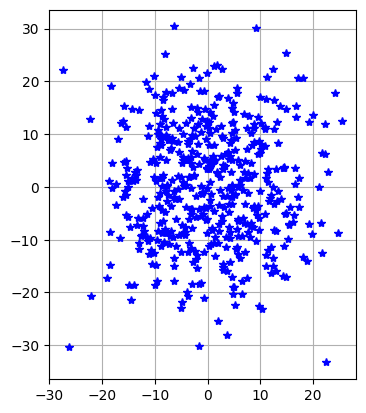

In [1]:
import random

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np


def plot_points(p, p0=[], r0=0.0):
    k = len(p)

    plt.rc("savefig", dpi=120)

    fig, ax = plt.subplots()
    ax.set_aspect("equal")
    ax.plot([p[i][0] for i in range(k)], [p[i][1] for i in range(k)], "b*")

    if len(p0) > 0:
        ax.plot(p0[0], p0[1], "r.")
        ax.add_patch(mpatches.Circle(p0, r0, fc="w", ec="r", lw=1.5))
    plt.grid()
    plt.show()


n = 2
k = 500

p = np.array([[random.gauss(0.0, 10.0) for nn in range(n)] for kk in range(k)])

plot_points(p)

## The problem

The problem boils down to determine the sphere center $p_0\in \mathbb{R}^n$ and its radius $r_0\geq 0$, i.e.


\begin{equation}
  \begin{aligned}
\min \max_{i=1,\dots,k} \| p_0 - p_i\|_2 \\
  \end{aligned}
\end{equation}

The maximum in the objective function can be easily, i.e.

\begin{equation}
  \begin{aligned}
\min r_0 & & &\\
s.t.& & &\\
& r_0 \geq \| p_0 - p_i\|_2 ,& \quad & i=1,\ldots,k\\
\end{aligned}
\end{equation}

The SOCP formulation reads

\begin{equation}
  \begin{aligned}
\min r_0 & & &\\
s.t.& & &\\
& \left[r_0,p_0 - p_i\right] \in Q^{(n+1)}, & \quad & i=1,\ldots,k.
\end{aligned}
\end{equation}

where $Q^{(n+1)} = \left\{ (t,x) ∈ \mathbb{R} \times \mathbb{R}^n : \|x\|_2  \leq t \right\}$ is the $(n+1)$ dimensional second-order cone.


### With n constraints: Distance from center for each point

Unaware of cones we could write this problem as 

In [2]:
import cvxpy as cp


def min_circle_cvx_norm(points, **kwargs):
    # cvxpy variable for the radius
    r = cp.Variable(shape=1, name="Radius")
    # cvxpy variable for the midpoint
    x = cp.Variable(points.shape[1], name="Midpoint")
    objective = cp.Minimize(r)
    constraints = [cp.norm2(x - point) <= r for point in points]

    problem = cp.Problem(objective=objective, constraints=constraints)
    problem.solve(**kwargs)

    return r.value[0], x.value

In [3]:
r0, p0 = min_circle_cvx_norm(p, solver="CLARABEL")
print("r0^* = ", r0)
print("p0^* = ", p0)

r0^* =  37.27250476895917
p0^* =  [-2.33549367 -5.41087228]


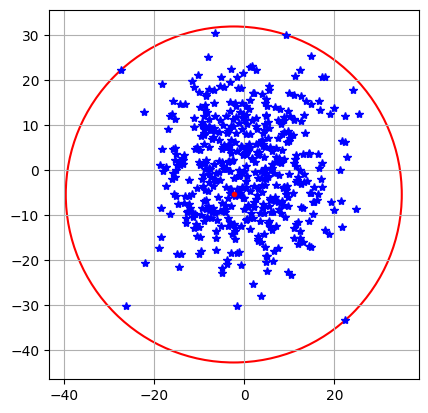

In [4]:
plot_points(p, p0, r0)

### With n constraints: One second-order cone for each point

Using cones we can replace each individual constraint with a cone. This syntactic sugar will reduce the runtime

In [5]:
def min_circle_cvx_socs(points, **kwargs):
    # cvxpy variable for the radius
    r = cp.Variable(shape=1, name="Radius")
    # cvxpy variable for the midpoint
    x = cp.Variable(points.shape[1], name="Midpoint")
    objective = cp.Minimize(r)
    constraints = [cp.SOC(r, point - x) for point in points]

    problem = cp.Problem(objective=objective, constraints=constraints)
    problem.solve(**kwargs)

    return r.value[0], x.value

In [6]:
r0, p0 = min_circle_cvx_socs(p, solver="CLARABEL")
print("r0^* = ", r0)
print("p0^* = ", p0)

r0^* =  37.27250344539602
p0^* =  [-2.33553826 -5.41091255]


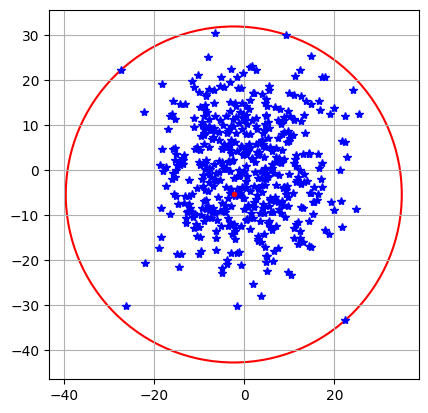

In [7]:
plot_points(p, p0, r0)

### With one constraint: Getting rid of loop

We follow Mosek's excellent documentation:

Before defining the constraints, we note that we can write

\begin{equation}
R_0 = \left( \begin{array}{c} r_0   \\ \vdots \\ r_0   \end{array} \right) \in \mathbb{R}^k          , \quad
P_0 = \left( \begin{array}{c} p_0^T \\ \vdots \\ p_0^T \end{array} \right) \in \mathbb{R}^{k\times n}, \quad
P   = \left( \begin{array}{c} p_1^T \\ \vdots \\ p_k^T \end{array} \right) \in \mathbb{R}^{k\times n}.
\end{equation}

so that 

\begin{equation}
\left[r_0,p_i - p_0\right] \in Q^{(n+1)},  \quad  i=1,\ldots,k.
\end{equation}

can be compactly expressed as 

\begin{equation}
\left[ R_0,P_0-P\right] \in \Pi Q^{(n+1)},
\end{equation}

that means, with a little abuse of notation, that each rows belongs to a quadratic cone of dimension $n+1$.

We can take over the idea for cvxpy and can get away with a single call of 'cp.SOC'. The loop has disappeared into matrix algebra which is in general a good idea when using Python.

In [8]:
def min_circle_cvx_soc(points, **kwargs):
    # cvxpy variable for the radius
    r = cp.Variable(shape=1, name="Radius")
    # cvxpy variable for the midpoint
    x = cp.Variable(points.shape[1], name="Midpoint")
    objective = cp.Minimize(r)
    constraints = [
        cp.SOC(
            r * np.ones(points.shape[0]),
            points - cp.outer(np.ones(points.shape[0]), x),
            axis=1,
        )
    ]

    problem = cp.Problem(objective=objective, constraints=constraints)
    problem.solve(**kwargs)

    return r.value[0], x.value

In [9]:
r0, p0 = min_circle_cvx_soc(p, solver="CLARABEL")
print("r0^* = ", r0)
print("p0^* = ", p0)

r0^* =  37.27250344539602
p0^* =  [-2.33553826 -5.41091255]


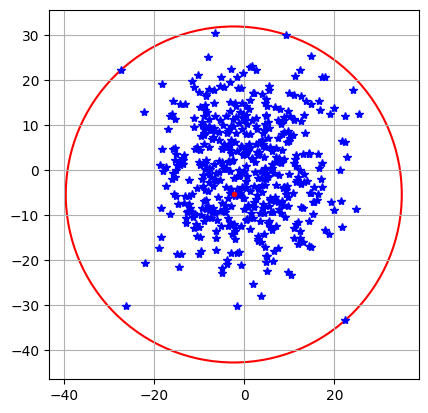

In [10]:
plot_points(p, p0, r0)

## Benchmark

We have demonstrated that all implementation above give the same results. So why bother? 

Using a more junky set of points we compare their runtime and reveal huge differences:

In [11]:
p = np.random.randn(10000, 5)

In [12]:
%%timeit
min_circle_cvx_norm(p, solver="CLARABEL")

6.98 s ± 791 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%%timeit
min_circle_cvx_socs(p, solver="CLARABEL")

5.28 s ± 182 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%%timeit
min_circle_cvx_soc(p, solver="CLARABEL")

252 ms ± 2.79 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Summary

Avoiding the loop explicitly constructing a second-order cone for each point leads to dramatic speed-ups.